# GitHub-Link
https://github.com/Tschoppsilas/GBSV_2025.git

# Tag 1
## Anwendungsfalls
In traditionellen Schweizer Alpkäsereien lagern Käselaibe auf Holzregalen zur Reifung. Eine automatisierte Erkennung und Zählung dieser Laibe auf Bildern – z.B. aus einer Produktionsüberwachung oder einem Kontrollsystem – kann zur Qualitätskontrolle, Bestandsaufnahme oder Prozessoptimierung beitragen. Besonders in kleinen, handwerklichen Betrieben kann so der Aufwand reduziert und die Nachverfolgbarkeit verbessert werden.

## Problemstellung
Die Käselaibe haben meist eine gleichmässige, runde Form und eine gelblich-bräunliche Färbung, die sich vom Holzregal oder dem dunkleren Reiferaumhintergrund abhebt. Je nach Lichtverhältnissen, Schatten oder teilweiser Überlappung kann die visuelle Trennung jedoch schwierig sein. Ziel ist es, diese gleichartigen Objekte automatisch zu segmentieren, ohne manuelles Zählen. Dies kann insbesondere dann herausfordernd sein, wenn Laibe eng beieinander liegen oder teilweise verdeckt sind.

## Ziel der Segmentierung
Durch die Segmentierung der Käselaibe im Bild soll eine zuverlässige Zählung, Lokalisierung und ggf. Flächenschätzung einzelner Laibe ermöglicht werden. Die daraus gewonnenen Daten können genutzt werden, um Lagerbestände zu automatisieren, Reifeverläufe über Zeiträume zu dokumentieren oder auch visuelle Auffälligkeiten (z.B. Schimmelbildung) frühzeitig zu erkennen – ein praktischer Nutzen für die Lebensmittelüberwachung und das digitale Alpkäsemanagement.

## Bild
Mein Bild, welches ich unten ausgebe, habe ich von folgender Webseite heruntergeladen.
https://www.loisirs.ch/agendas/32860/les-secrets-de-la-fabrication-de-fromage-d-alpage-a-la-poyettaz


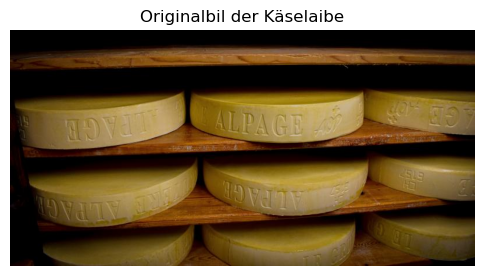

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Bild anzeigen
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Originalbil der Käselaibe")
plt.show()

# Tag 6

Gezählte Käselaibe: 9


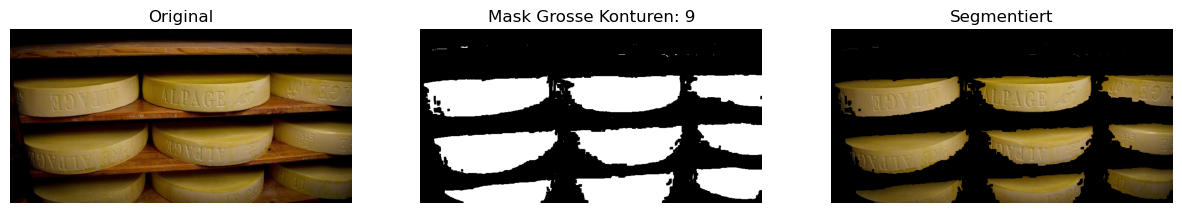

In [496]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Farbsegmentierung (LAB)
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

# Maske bereinigen
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Konturen finden und nach Fläche filtern
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 4000
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Ergebnis
num_objects = len(large_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# Segmentiertes Bild erstellen
result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.title("Original"), plt.imshow(img_rgb), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Mask Grosse Konturen: {num_objects}"), plt.imshow(mask_cleaned, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Segmentiert"), plt.imshow(result), plt.axis("off")
plt.show()

Die Histogramme zeigen die Verteilung der Farbwerte in den LAB-Kanälen. Daraus lassen sich Schwellenwerte ableiten, um den Farbton der Käselaibe gezielt zu isolieren.


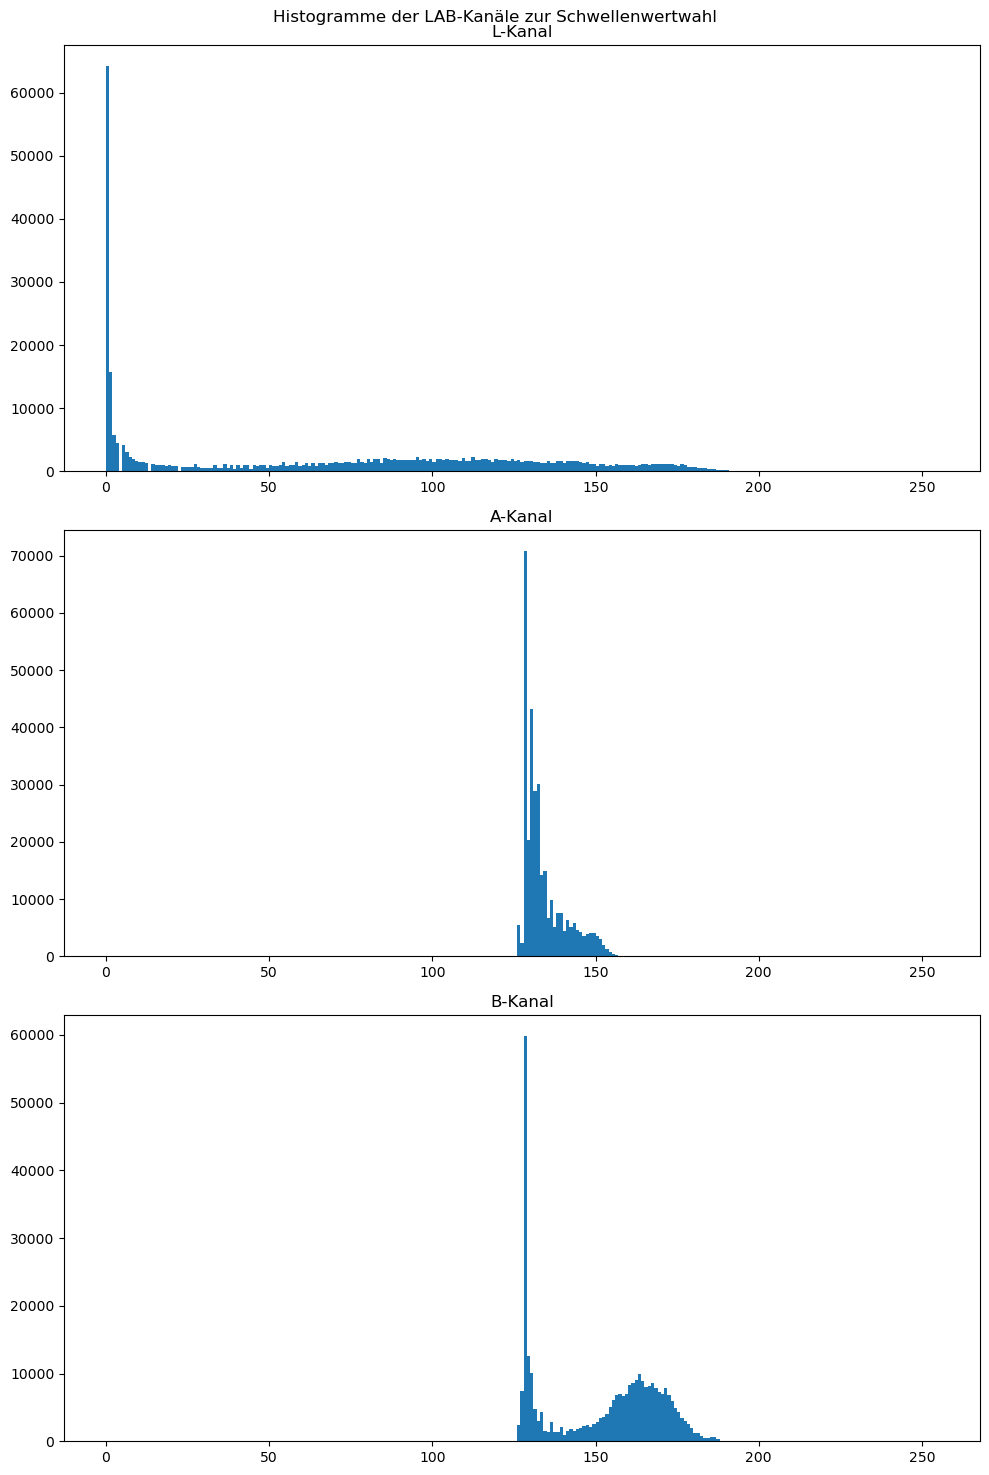

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab)

# Histogramme anzeigen

# Histogramme anzeigen
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1), plt.hist(l_channel.ravel(), bins=255, range=[0, 255]), plt.title("L-Kanal")
plt.subplot(3, 1, 2), plt.hist(a_channel.ravel(), bins=255, range=[0, 255]), plt.title("A-Kanal")
plt.subplot(3, 1, 3), plt.hist(b_channel.ravel(), bins=255, range=[0, 255]), plt.title("B-Kanal")
plt.suptitle("Histogramme der LAB-Kanäle zur Schwellenwertwahl")
plt.tight_layout()
plt.show()

Gezählte Käselaibe: 9


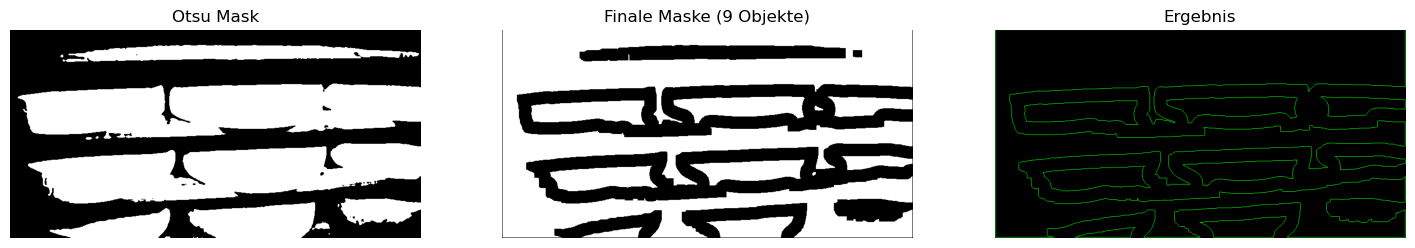

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Rauschreduzierung (angepasste Parameter)
blurred = cv2.medianBlur(gray, 5)  # Besser bei Salz-Pfeffer-Rauschen als GaussianBlur

# 3. Thresholding (Otsu, nicht invertiert!)
_, otsu_mask = cv2.threshold(blurred, 190, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4. Kleine Störungen entfernen (Rauschen filtern)
kernel = np.ones((5,5), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel, iterations=3)  # Entfernt kleine weisse Punkte

# 5. Watershed vorbereiten
dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)  # Marker für Laibe
sure_fg = np.uint8(sure_fg)

# 6. Watershed anwenden
unknown = cv2.subtract(opened, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 0] = 100
markers = cv2.watershed(img, markers)

# 7. Ergebnis extrahieren (Nur Objekte, kein Hintergrund/Rauschen)
final_mask = np.zeros_like(gray, dtype=np.uint8)
final_mask[markers > 1] = 100  # Marker >1 = Käselaibe

# 8. Konturen zählen (nur grosse Flächen)
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 1000  # Mindestfläche für einen Käselaib (anpassen!)
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
num_objects = len(valid_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# 9. Visualisierung
colored_labels = np.zeros_like(img)
for i, cnt in enumerate(valid_contours):
    cv2.drawContours(colored_labels, [cnt], 0, (0, 255, 0), 1)  # Grüne Konturen

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1), plt.title("Otsu Mask"), plt.imshow(otsu_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Finale Maske ({num_objects} Objekte)"), plt.imshow(final_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Ergebnis"), plt.imshow(colored_labels), plt.axis("off")
plt.show()

Durch Vergleich der verschiedenen Kernelgrössen wurde festgestellt, dass ein 5x5-Kernel das beste Verhältnis zwischen Glättung und Erhalt feiner Strukturen bietet.

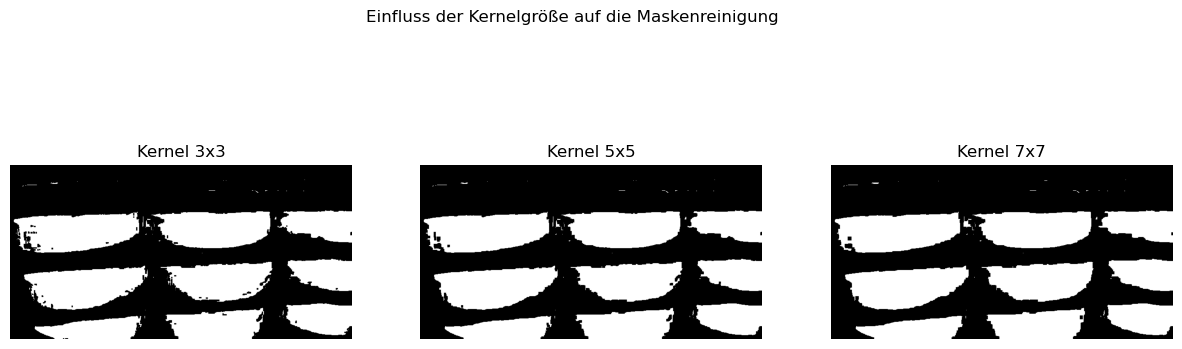

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Bild einlesen und in LAB konvertieren
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Schwellenwerte für LAB-Farbraum (wie im ursprünglichen Notebook)
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

kernel_sizes = [3, 5, 7]
plt.figure(figsize=(15, 5))
for i, k in enumerate(kernel_sizes):
    kernel = np.ones((k, k), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    plt.subplot(1, len(kernel_sizes), i + 1)
    plt.imshow(cleaned, cmap='gray')
    plt.title(f"Kernel {k}x{k}")
    plt.axis('off')
plt.suptitle("Einfluss der Kernelgrösse auf die Maskenreinigung")
plt.show()

Diese Grafik zeigt, wie sich die Mindestfläche auf die Objektanzahl auswirkt. Bei 1000 px wurde der letzte runde Wert gefunden, welcher noch alle 9 Käse erkennt

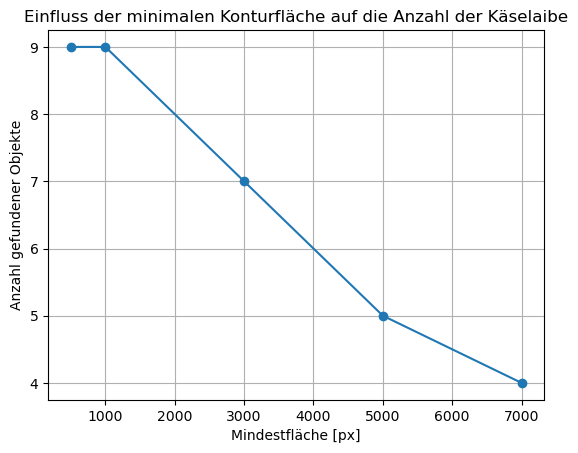

In [25]:
areas = [500, 1000, 3000, 5000, 7000]
counts = []

for min_area in areas:
    filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    counts.append(len(filtered))

plt.figure()
plt.plot(areas, counts, marker='o')
plt.title("Einfluss der minimalen Konturfläche auf die Anzahl der Käselaibe")
plt.xlabel("Mindestfläche [px]")
plt.ylabel("Anzahl gefundener Objekte")
plt.grid(True)
plt.show()
